<a href="https://colab.research.google.com/github/AbdelRayan/ThetaGammaAnalysis/blob/main/notebooks/Tutorial_1_Theta_Signal_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
## Initialzing and loading required libraries and subfunctions
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.interpolate import griddata
import copy
import scipy.fft
import scipy.stats
import numpy as np
import emd as emd
import scipy.io as sio
import seaborn as sns
import pandas as pd
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from sklearn.preprocessing import normalize


In [ ]:
# Scientific to Float Print Format
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.7f}'.format})

# Application of Methodology

The objective is to create a dataset of theta cycles where each theta cycle will be stored as a representation of a period cycle with a central peak as a group of indices. In order to properly extract theta cycles we will be employing a combination of methodlogical techniques from these two papers:

1. [Zhang, L., Lee, J., Rozell, C., & Singer, A. C. (2019). Sub-second dynamics of theta-gamma coupling in hippocampal CA1. eLife, 8. doi:10.7554/elife.44320 ](https://elifesciences.org/articles/44320):

2. [Lopes-dos-Santos, V., van de Ven, G. M., Morley, A., Trouche, S., Campo-Urriza, N., &amp; Dupret, D. (2018). Parsing hippocampal theta oscillations by nested spectral components during spatial exploration and memory-guided behavior. Neuron, 100(4). doi:10.1016/j.neuron.2018.09.031 ](https://www.cell.com/neuron/fulltext/S0896-6273(18)30833-X)







# Theta Signal Extraction

In this tutorial, we will be demonstrating our methods to extract the theta band signal using a recorded channel of hippocampal signal oscillations.

## Sleep Extraction

In this segment the Rat4 SD1 Dataset is loaded and the sleep states using the provided ES states file are identified utilising the ```sleep['transitions']``` key in the ```states.mat``` file.
- First we load the hippocampal readings and the REM states .mat files
- Segment ```sleep['states']``` timestamps into it's appropiate REM periods.


In [ ]:
# Loading data
lfp=np.squeeze(sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/HPC_100_CH42_0.continuous.mat')['HPC'])
states=np.squeeze(sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/2022-02-08_14-47-29_posttrial5-states_TS.mat')['states'])

In [ ]:
def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states from a binary sleep state vector.

    Parameters:
    states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.

    Returns:
    numpy.ndarray: An array of consecutive REM sleep state intervals in seconds, represented as (start, end) pairs.

    Notes:
    - This function processes a binary sleep state vector and identifies consecutive REM sleep intervals.
    - It calculates the start and end times of each REM state interval based on the provided sample rate.
    - The resulting intervals are returned as a numpy array of (start, end) pairs in seconds.
    """
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states

In [ ]:
s_rate= 2500
rem_states=get_rem_states(states, s_rate).astype(int)

for i,rem in enumerate(rem_states,start=1):
  print(f'REM {i} is from {rem[0]/s_rate} seconds (@ index {rem[0]}) to {rem[1]/s_rate} seconds (@ index {rem[1]})')

REM 1 is from 1215.0 seconds (@ index 3037500) to 1261.0 seconds (@ index 3152500)
REM 2 is from 1619.0 seconds (@ index 4047500) to 1634.0 seconds (@ index 4085000)
REM 3 is from 4354.0 seconds (@ index 10885000) to 4371.0 seconds (@ index 10927500)
REM 4 is from 4678.0 seconds (@ index 11695000) to 4765.0 seconds (@ index 11912500)
REM 5 is from 5452.0 seconds (@ index 13630000) to 5490.0 seconds (@ index 13725000)
REM 6 is from 5939.0 seconds (@ index 14847500) to 6073.0 seconds (@ index 15182500)
REM 7 is from 6945.0 seconds (@ index 17362500) to 7002.0 seconds (@ index 17505000)
REM 8 is from 10093.0 seconds (@ index 25232500) to 10136.0 seconds (@ index 25340000)


# Empirical mode decomposition
- REM signals require a certain level of pretreatment in order to extract the theta signals, and detect the cycles and their respective timestamps
- The pretreatment is to apply empirical mode decomposition to extract the intrinsic mode functions

<Axes: xlabel='Time (samples)'>

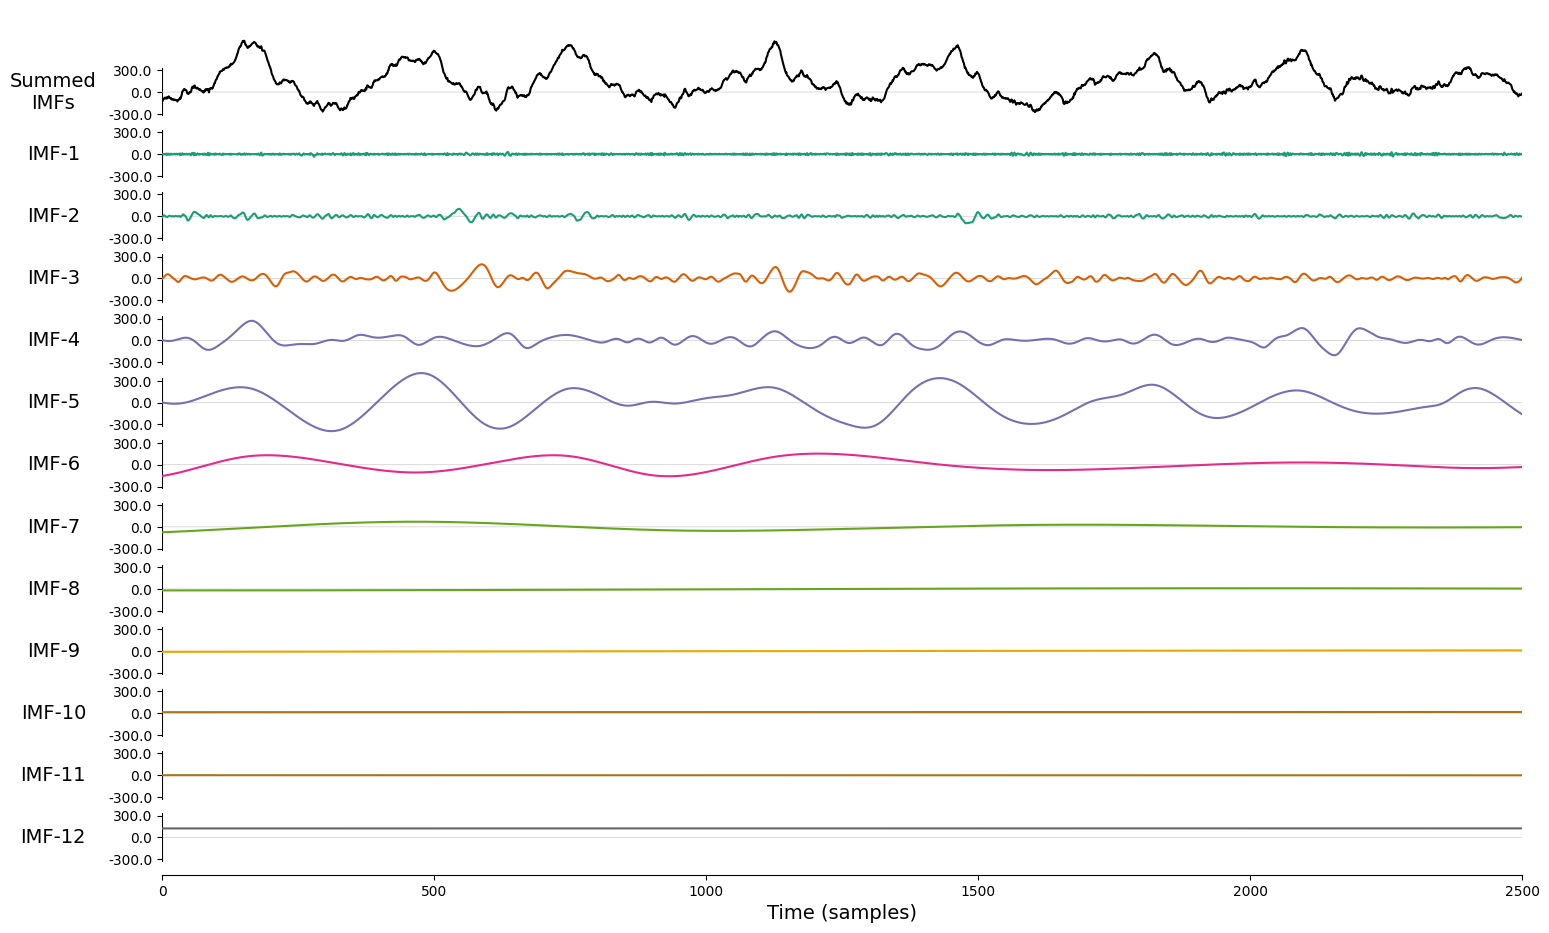

In [ ]:
#@title Signal decomposition using regular sift
#@markdown In this example, let's sift the first REM period using ```emd.sift.sift()```
first_rem=lfp[rem_states[0,0]:rem_states[0,1]]
sift=emd.sift.sift(first_rem)

# Display the first second (2500 samples)
emd.plotting.plot_imfs(sift[:2500,:])

## Figure plots of different sift methods

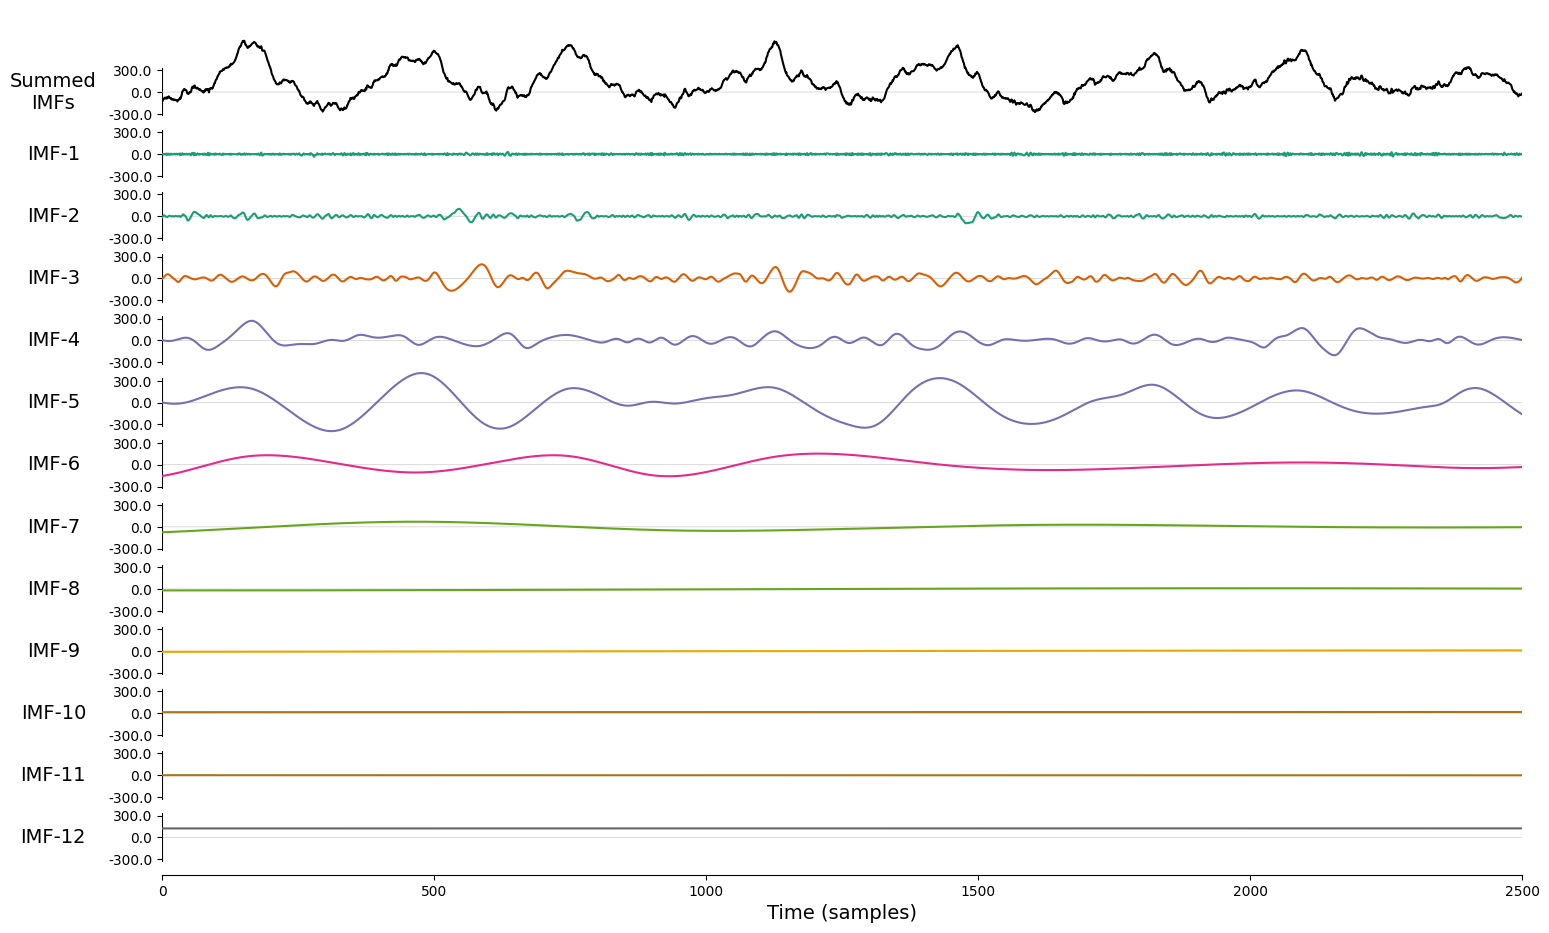

In [ ]:
#@title ### Normal Sift
sift=emd.sift.sift(first_rem)
siftfig=emd.plotting.plot_imfs(sift[:2500,:]).get_figure()

Ensemble Sift


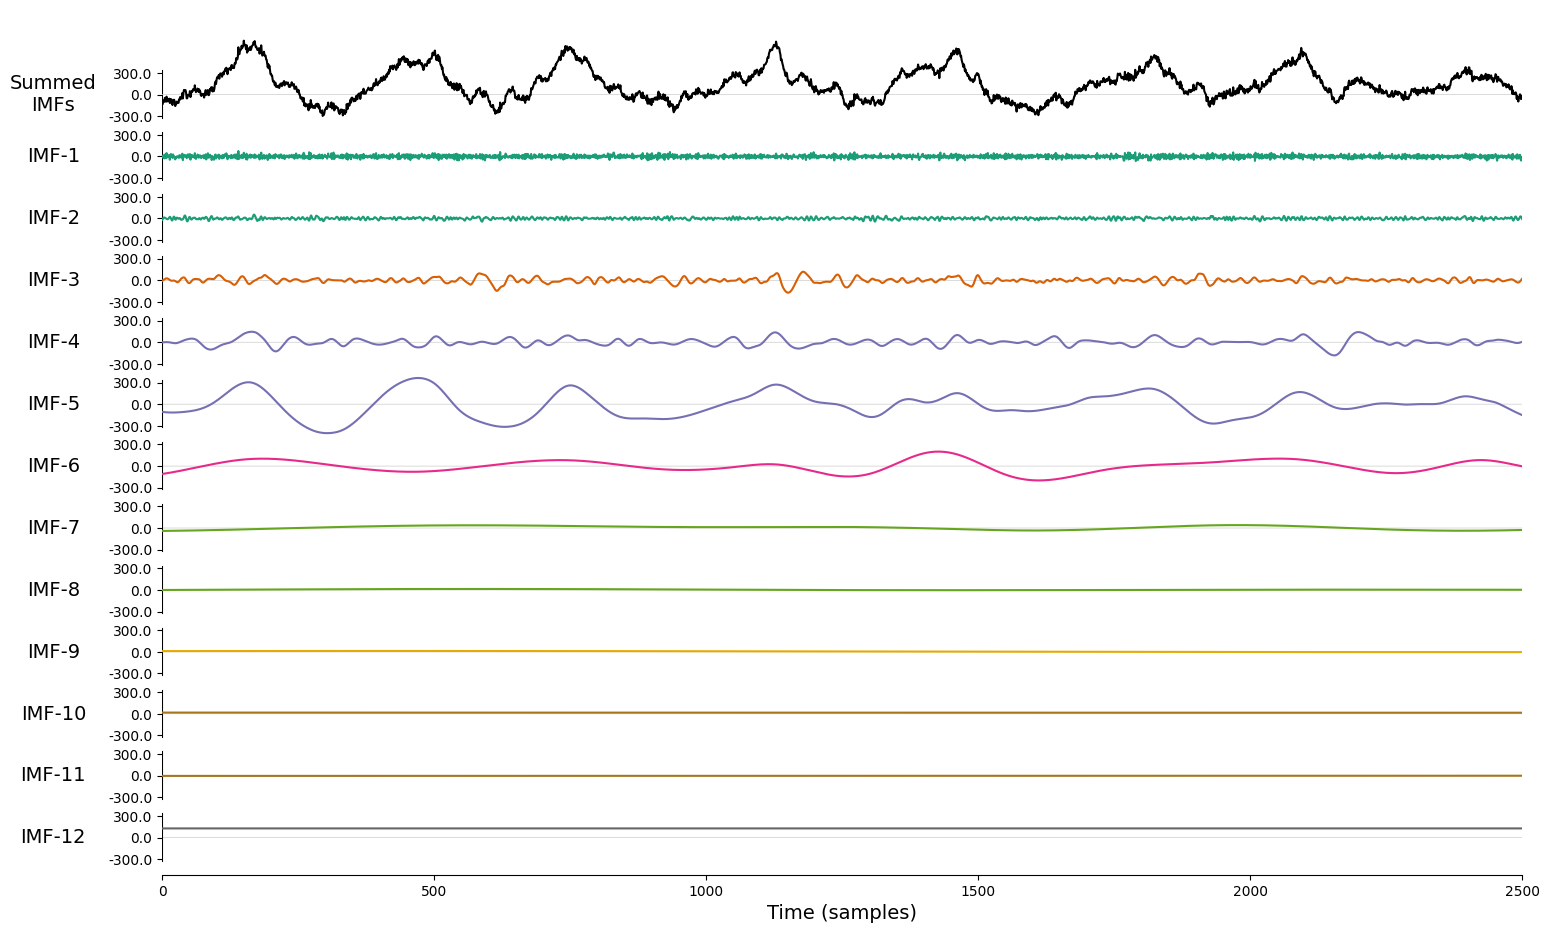

In [ ]:
#@title ### Ensemble Sift
print('Ensemble Sift')
ensemble=emd.sift.ensemble_sift(first_rem)
ensemblefig=emd.plotting.plot_imfs(ensemble[:2500,:]).get_figure()

Complete Ensemble Sift


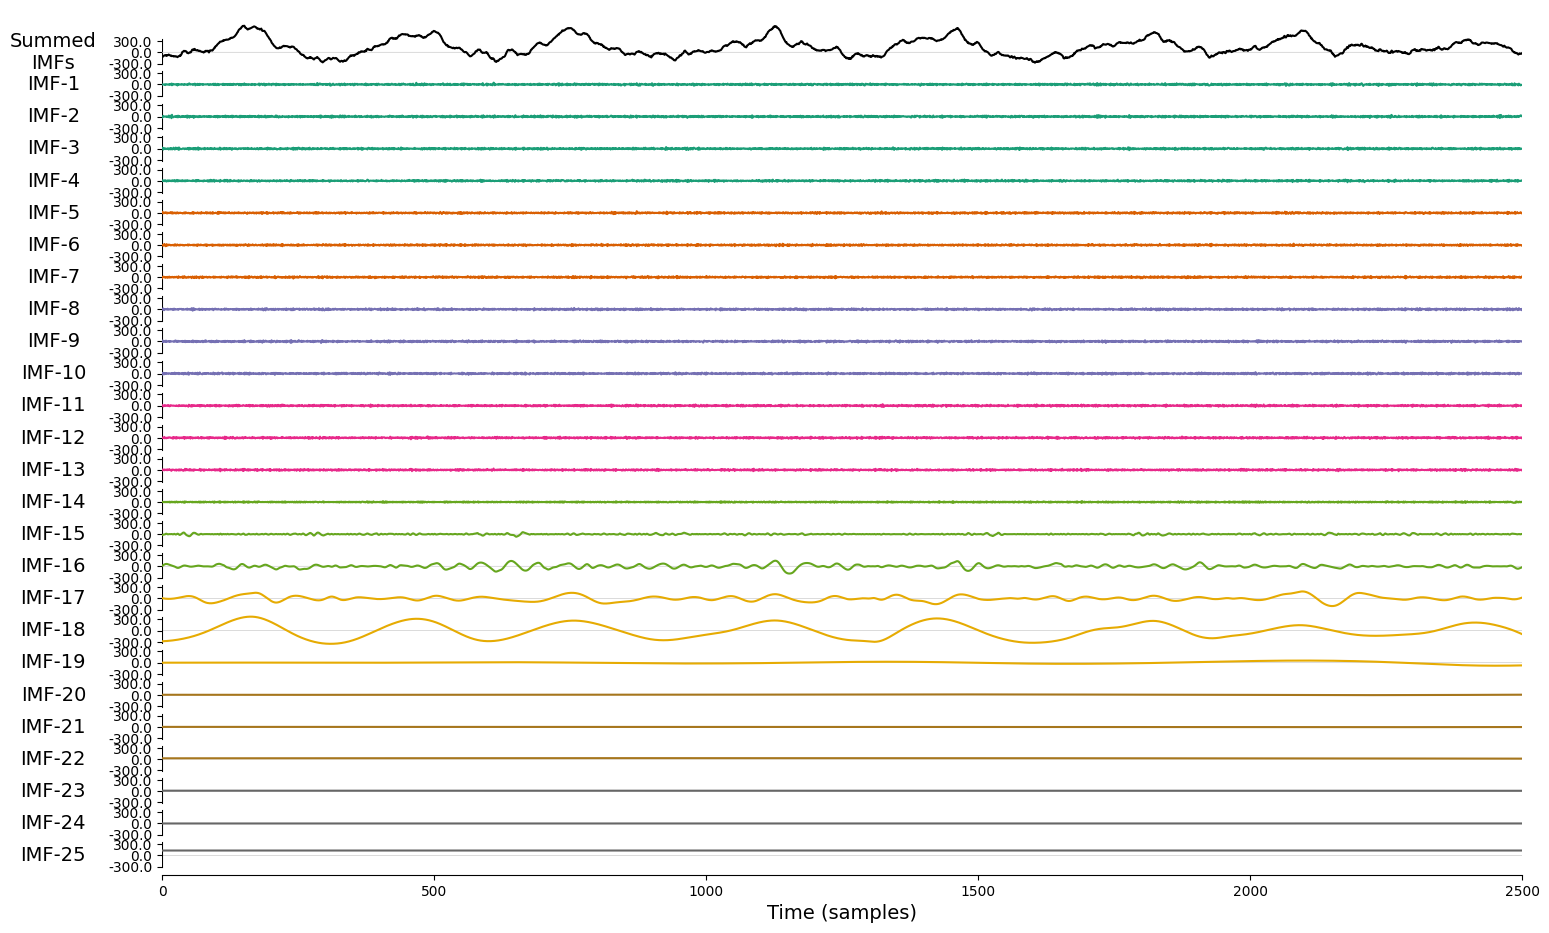

In [ ]:
#@title ### Complete Ensemble Sift
print('Complete Ensemble Sift')
censemble,noise=emd.sift.complete_ensemble_sift(first_rem)
censemblefig=emd.plotting.plot_imfs(censemble[:2500,:]).get_figure()

Masked Sift Zero Cross Setting


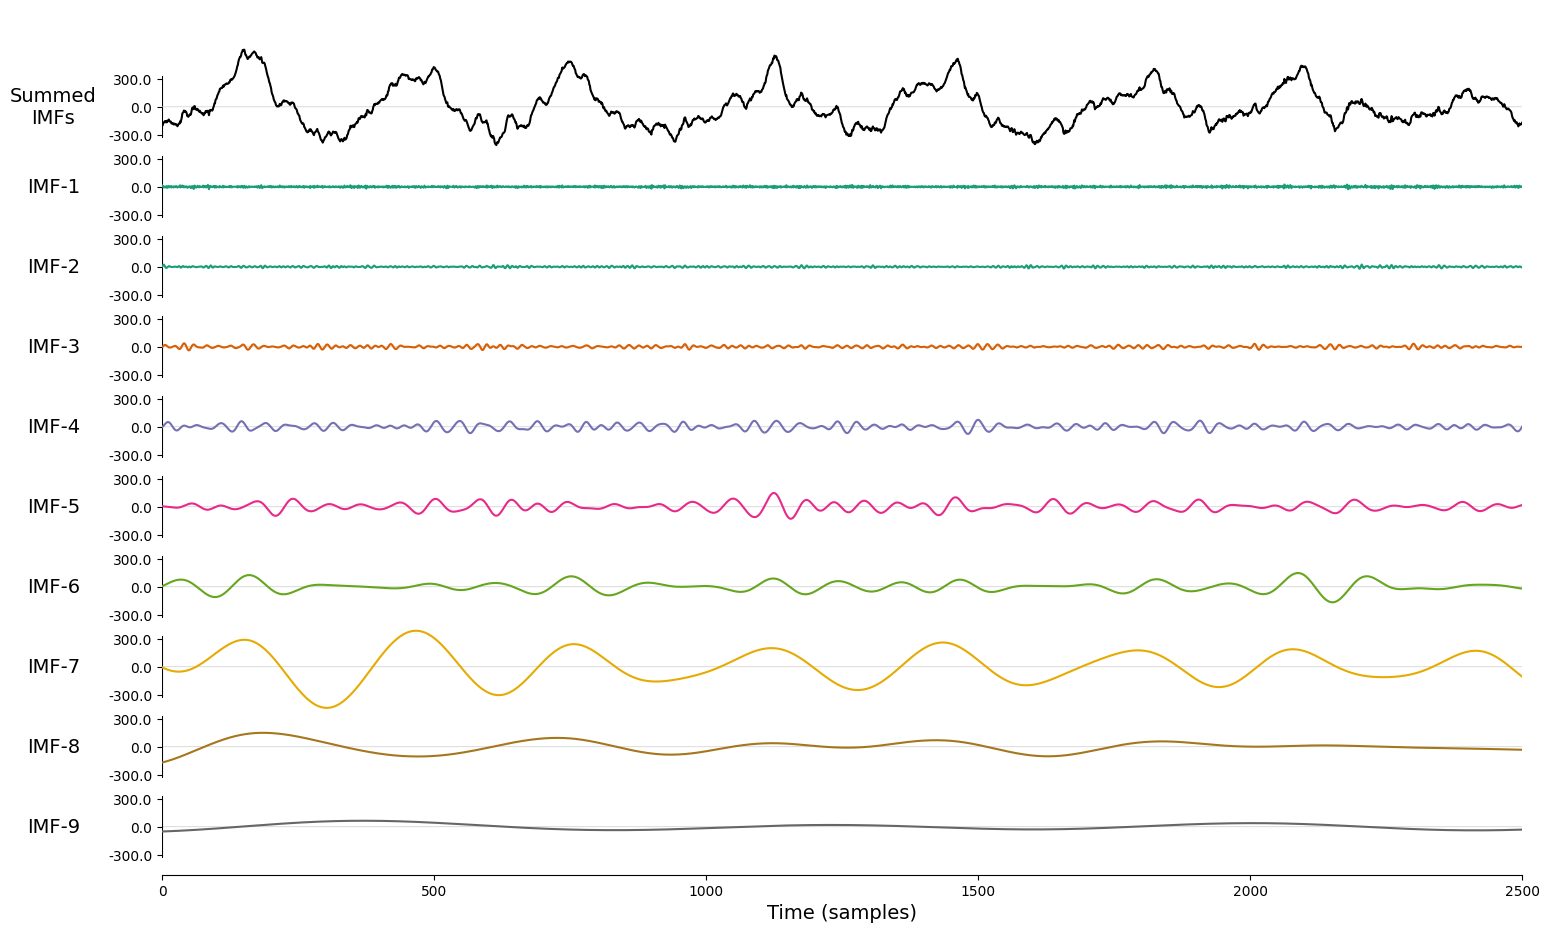

In [ ]:
#@title ### Masked Sift Zero Cross Setting
print('Masked Sift Zero Cross Setting')
maskzc=emd.sift.mask_sift(first_rem,mask_freqs='zc',ret_mask_freq='True')
maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()

Masked Sift Instantaneous Frequency Setting


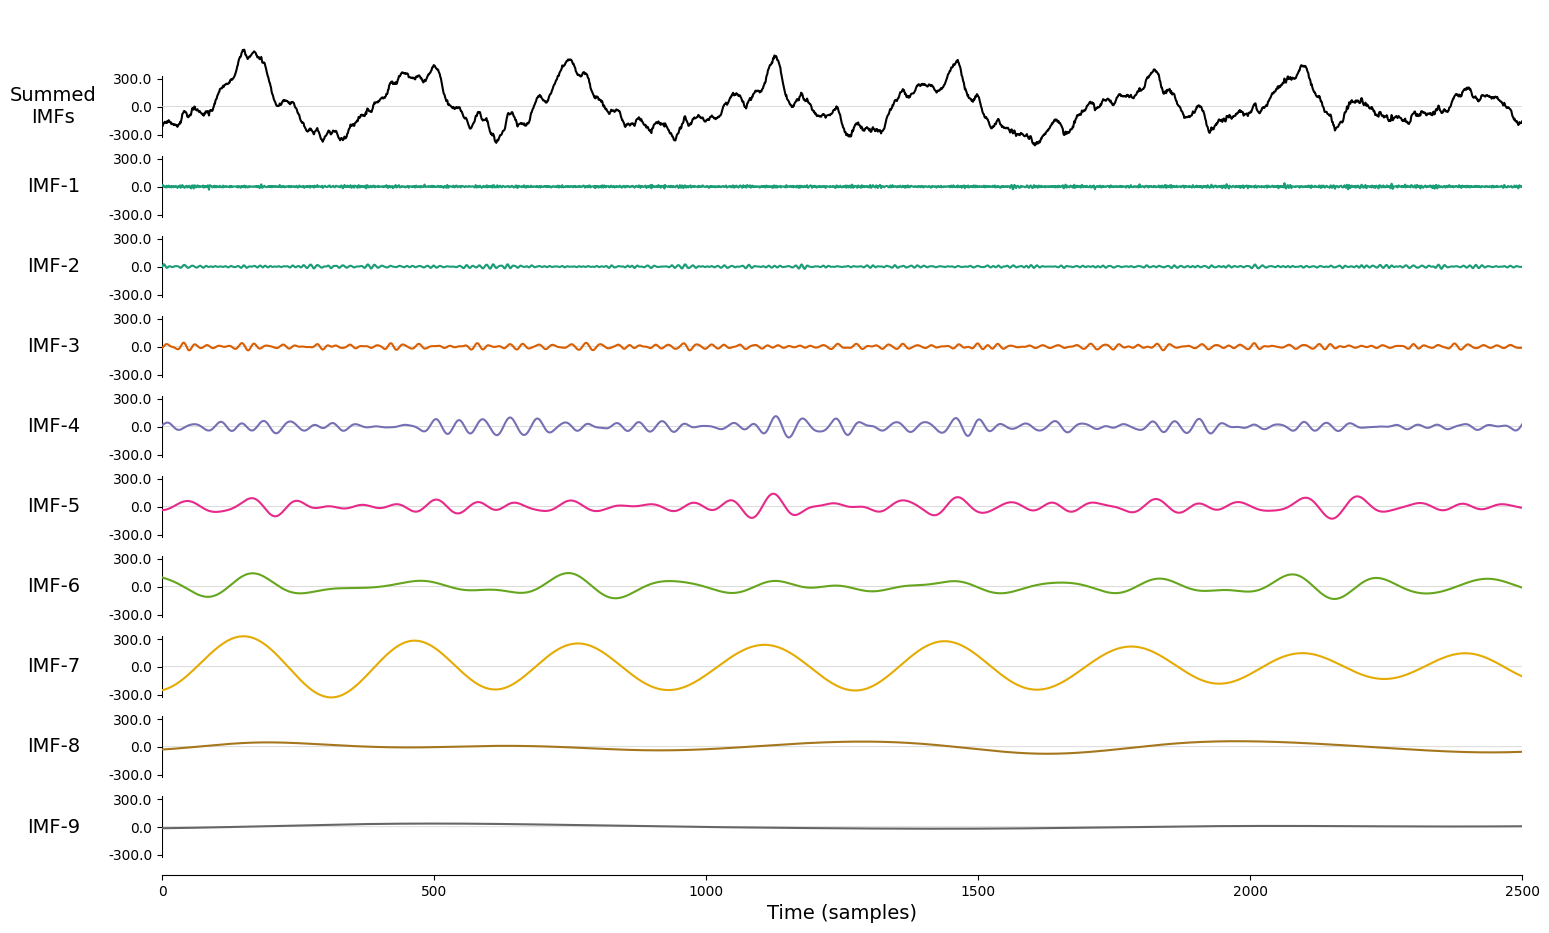

In [ ]:
#@title ### Masked Sift Instantaneous Frequency Setting
print('Masked Sift Instantaneous Frequency Setting')
maskif=emd.sift.mask_sift(first_rem,mask_freqs='if',ret_mask_freq='True')
maskiffig=emd.plotting.plot_imfs(maskif[0][:2500,:]).get_figure()

Iterated Masked Sift Zero Cross Setting


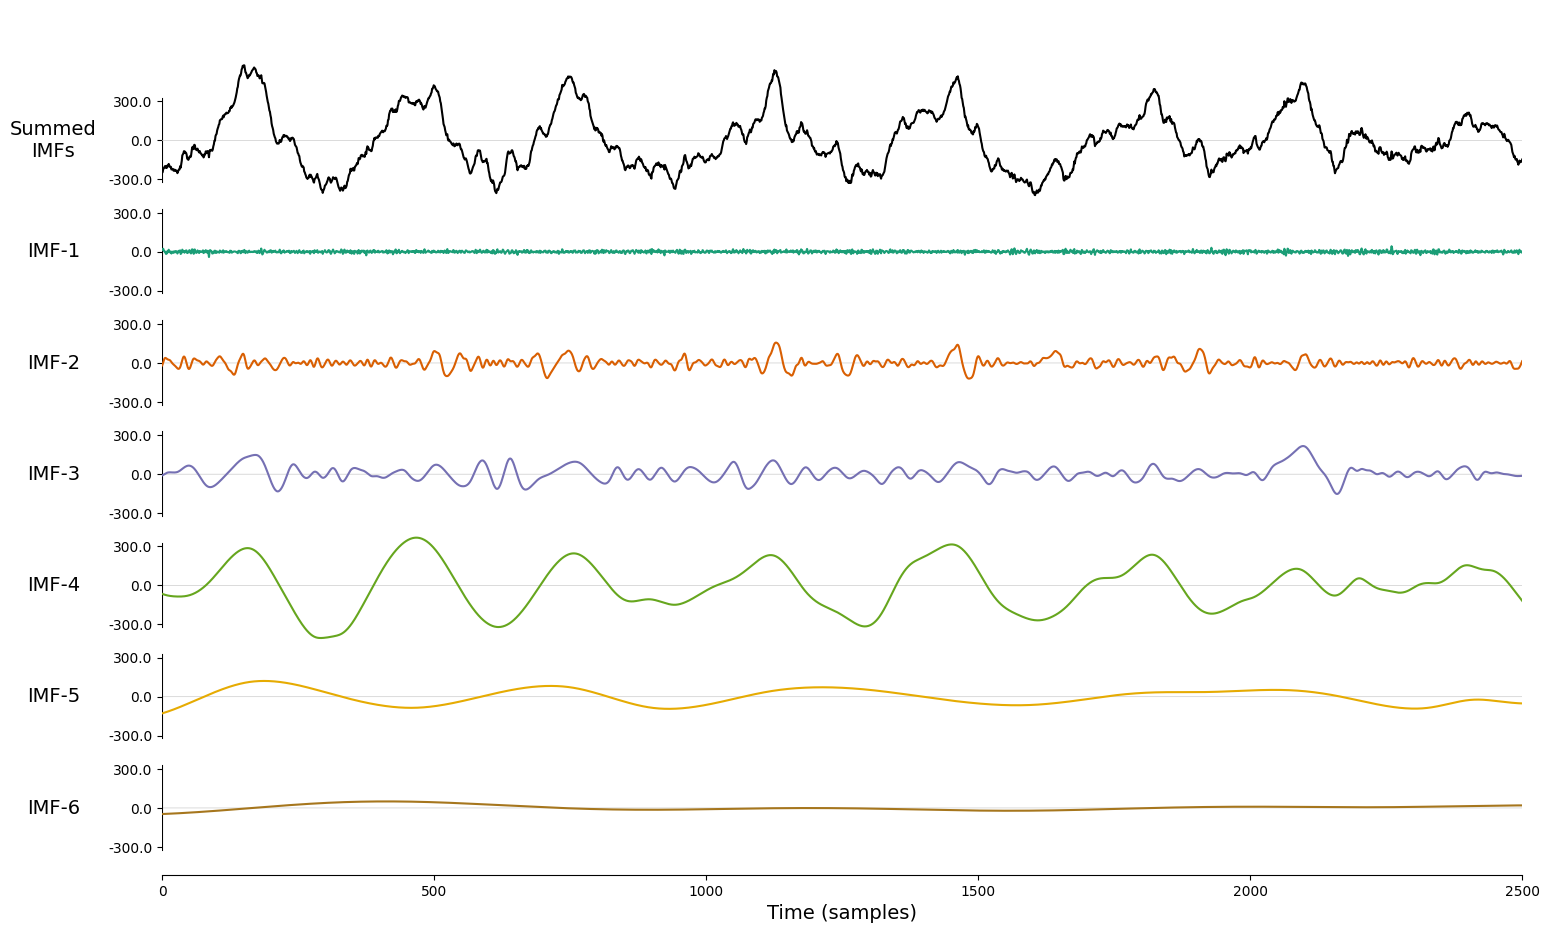

In [ ]:
#@title ### Iterated Masked Sift Zero Cross Setting
print('Iterated Masked Sift Zero Cross Setting')
imask=emd.sift.iterated_mask_sift(first_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')
imaskzcfig=emd.plotting.plot_imfs(imask[0][:2500,:]).get_figure()

# Theta signal extraction from **I**ntrisic **M**ode **F**unction(s) (IMF)

In order to extract theta signals, the raw signal is a summation of signal sources of various frequencies. Since we are targeting for theta oscillations we're mostly looking for signal behavior in the 5-12 Hz range.

Below is a demonstration of  signal behavior in the theta range using a bandpass filter

In [ ]:
# Create the time vector

time=len(first_rem)/s_rate
seconds=np.linspace(0,time,len(first_rem))

In [ ]:

Wlo = [5,12]
Whi=[60,80]# Set the passband [2-10] Hz,
n = 50;                            # ... and filter order,
                                    # ... build the bandpass filter,
a = signal.firwin(n, Wlo, fs=s_rate, pass_zero=False, window='hamming');
b = signal.firwin(n, Whi, fs=s_rate, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(a, 1, first_rem);   # ... and apply it to the data.
Vhi= signal.filtfilt(b, 1, first_rem);
VloX=scipy.fft.fft(Vlo)
VhiX=scipy.fft.fft(Vhi)
VloXA=2*abs(VloX)/len(first_rem)
VhiXA=2*abs(VhiX)/len(first_rem)


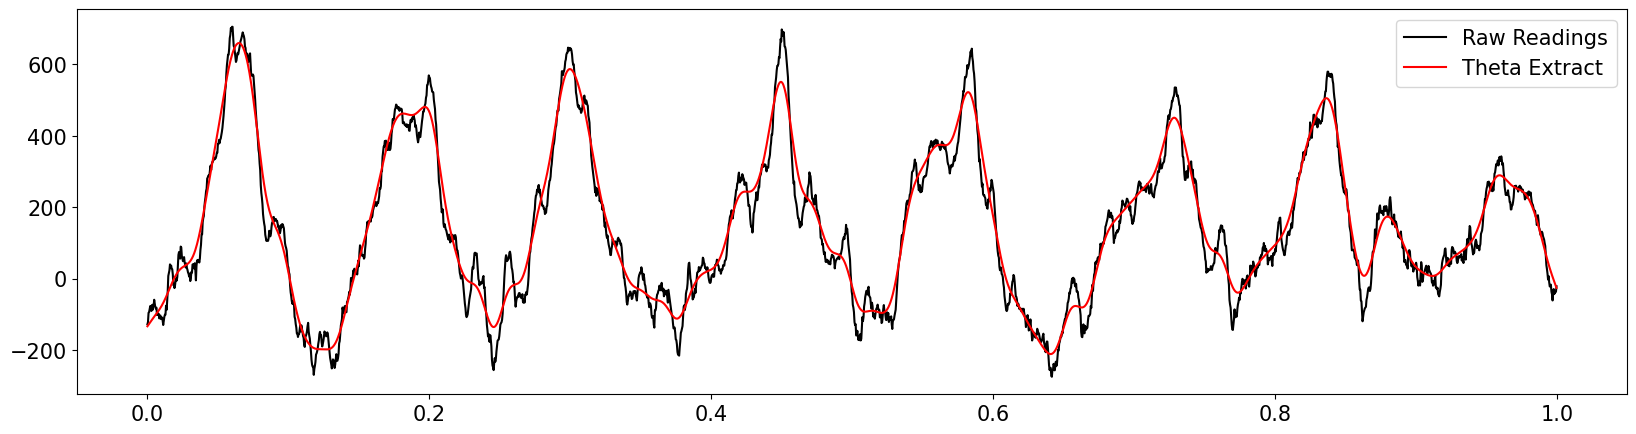

In [ ]:
#@title Example of frequency filtered theta signal

plt.gcf().set_size_inches(20, 5)
plt.rcParams.update({'font.size': 15})
# plt.plot(seconds[:sample_rate],Vhi[:sample_rate])
plt.plot(seconds[:s_rate],first_rem[:s_rate],'-k',label='Raw Readings')
plt.plot(seconds[:s_rate],Vlo[:s_rate],'-r',label='Theta Extract')

plt.legend(loc="upper right")


## Defining the theta-gamma split function


While we can extract theta signals using a bandpass filter we can also extract using the sifting technique, where once the intrinsic mode functions are determined, we would analyse each IMF signal for their average frequency behavior and select the individual frequencies that lie within the theta range

In [ ]:
# Define a simple function to calcuclate the average frequencies of each IMF

def imf_freq(imf,sample_rate,mode='nht'):
  _,IF,_=emd.spectra.frequency_transform(imf,sample_rate,'nht')
  freq_vec=np.mean(IF,axis=0)
  return freq_vec

In [ ]:
# Example of the average frequencies calculated from IMFs of normal sifting

sift_mask_freq= imf_freq(sift,s_rate)
print(f'{sift_mask_freq} in Hz')

[599.4809570 227.2536561 75.7597743 24.5847092 7.7122541 3.3019243
 1.4765132 0.6301636 0.3028592 0.1503969 0.0420242 -0.0001670] in Hz


In [ ]:
# Defining the theta gamma split function

def tg_split(mask_freq, theta_range=(5, 12)):
    """
        Split a frequency vector into sub-theta, theta, and supra-theta components.

        Parameters:
        mask_freq (numpy.ndarray): A frequency vector or array of frequency values.
        theta_range (tuple, optional): A tuple defining the theta frequency range (lower, upper).
            Default is (5, 12).

        Returns:
        tuple: A tuple containing boolean masks for sub-theta, theta, and supra-theta frequency components.

        Notes: - This function splits a frequency mask into three components based on a specified theta frequency
        range. - The theta frequency range is defined by the 'theta_range' parameter. - The resulting masks 'sub',
        'theta', and 'supra' represent sub-theta, theta, and supra-theta frequency components.
    """
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index

    return sub, theta, supra

## Comparison of theta signal extraction to raw signal from different sifting methods

Text(0.5, 1.0, 'Complete Ensemble sift')

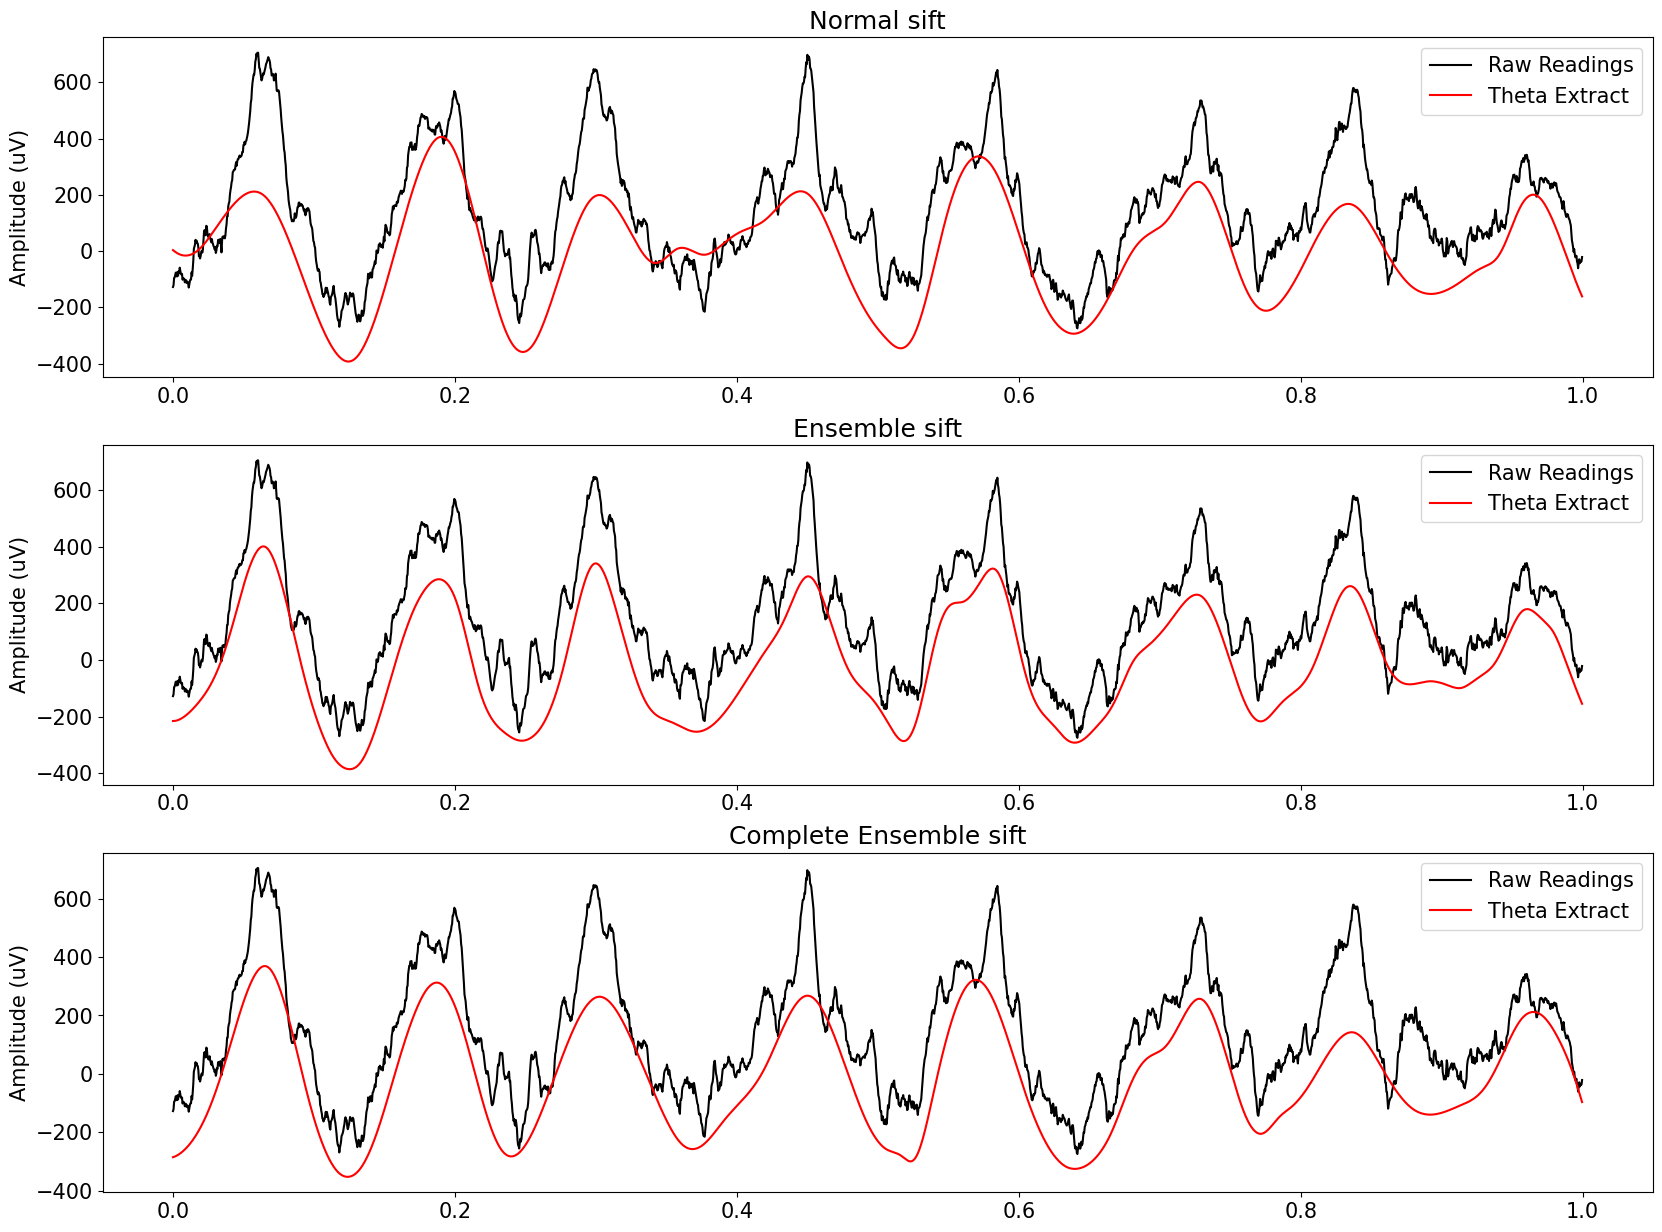

In [ ]:
#@markdown ### Extracting the IMFs in the theta frequency range and constructing the theta signal

#@markdown Below is a plot representation of the constructed theta signal from different sift methods and it's comparison to the raw signal
#Creating the subplot
fig1,ax1=plt.subplots(3,figsize=(20,15))
plt.rcParams.update({'font.size': 15})

#Normal sift
_,sift_theta,_=tg_split(sift_mask_freq)
sift_thetasig= np.sum(sift.T[sift_theta],axis=0)
ax1[0].plot(seconds[:2500],first_rem[:2500],'-k',label='Raw Readings')
ax1[0].plot(seconds[:2500],sift_thetasig[:2500],'-r',label='Theta Extract')
ax1[0].legend(loc="upper right")
ax1[0].set_ylabel(r'Amplitude (uV)')
ax1[0].set_title('Normal sift')

##### Ensemble Sift
ensemble_mask_freq= imf_freq(ensemble,s_rate)
_,ensemble_theta,_=tg_split(ensemble_mask_freq)
ensemble_thetasig= np.sum(ensemble.T[ensemble_theta],axis=0)
ax1[1].plot(seconds[:2500],first_rem[:2500],'-k',label='Raw Readings')
ax1[1].plot(seconds[:2500],ensemble_thetasig[:2500],'-r',label='Theta Extract')
ax1[1].legend(loc="upper right")
ax1[1].set_ylabel(r'Amplitude (uV)')
ax1[1].set_title('Ensemble sift')

##### Complete Ensemble Sift
censemble_mask_freq= imf_freq(censemble,s_rate)
_,censemble_theta,_=tg_split(censemble_mask_freq)
censemble_thetasig= np.sum(censemble.T[censemble_theta],axis=0)
ax1[2].plot(seconds[:2500],first_rem[:2500],'-k',label='Raw Readings')
ax1[2].plot(seconds[:2500],censemble_thetasig[:2500],'-r',label='Theta Extract')
ax1[2].legend(loc="upper right")
ax1[2].set_ylabel(r'Amplitude (uV)')
ax1[2].set_title('Complete Ensemble sift')

Text(0.5, 1.0, 'Iterated Mask Sift')

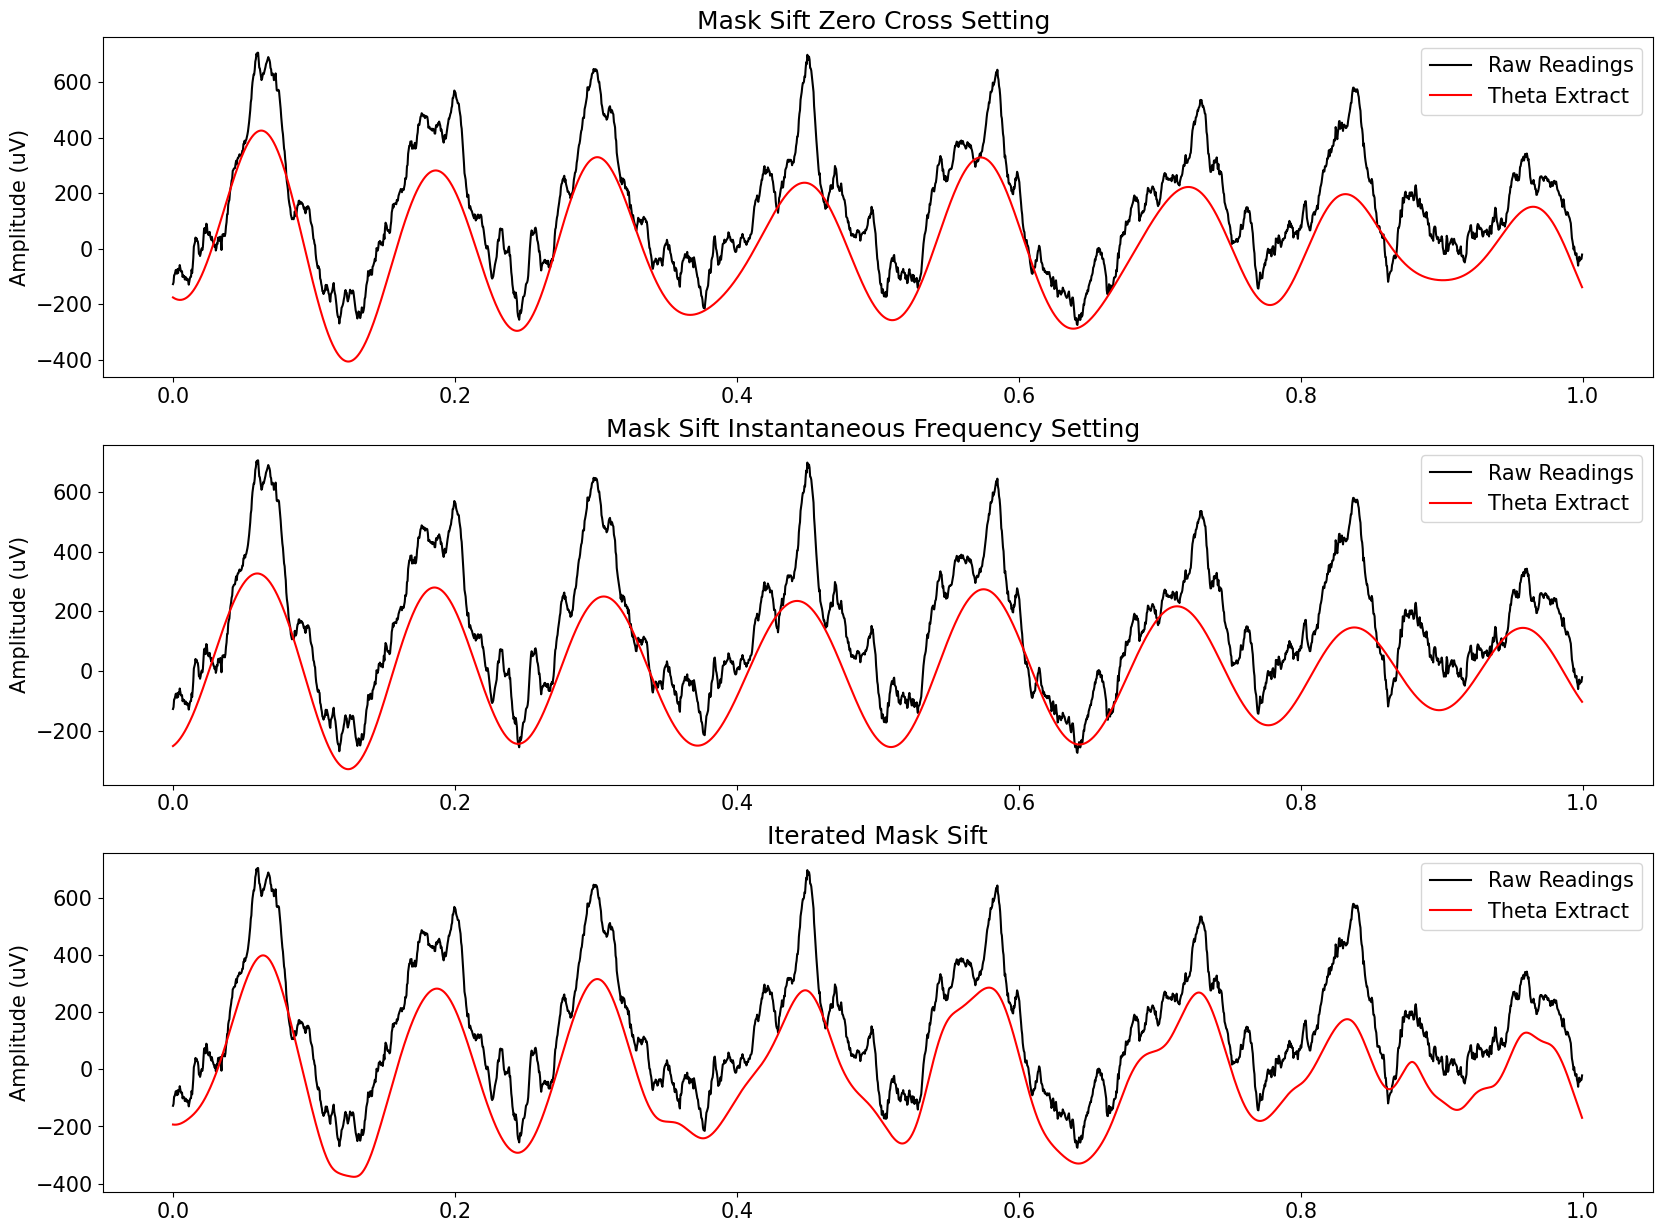

In [ ]:
#@markdown Below is a plot representation of the constructed theta signal and it's comparison to the raw signal
#Creating the subplot
fig2,ax2=plt.subplots(3,figsize=(20,15))
plt.rcParams.update({'font.size': 15})

# Mask Sift Zero Cross Setting
_,maskzc_theta,_=tg_split(maskzc[1]*s_rate)
maskzc_thetasig= np.sum(maskzc[0].T[maskzc_theta],axis=0)
ax2[0].plot(seconds[:2500],first_rem[:2500],'-k',label='Raw Readings')
ax2[0].plot(seconds[:2500],maskzc_thetasig[:2500],'-r',label='Theta Extract')
ax2[0].legend(loc="upper right")
ax2[0].set_ylabel(r'Amplitude (uV)')
ax2[0].set_title('Mask Sift Zero Cross Setting ')

# Mask Sift Instantaneous Frequency Setting
_,maskif_theta,_=tg_split(maskif[1]*s_rate)
maskif_thetasig= np.sum(maskif[0].T[maskif_theta],axis=0)
ax2[1].plot(seconds[:2500],first_rem[:2500],'-k',label='Raw Readings')
ax2[1].plot(seconds[:2500],maskif_thetasig[:2500],'-r',label='Theta Extract')
ax2[1].legend(loc="upper right")
ax2[1].set_ylabel(r'Amplitude (uV)')
ax2[1].set_title('Mask Sift Instantaneous Frequency Setting ')

# Iterated Mask Sift
_,imask_theta,_=tg_split(imask[1])
imask_thetasig= np.sum(imask[0].T[imask_theta],axis=0)
ax2[2].plot(seconds[:2500],first_rem[:2500],'-k',label='Raw Readings')
ax2[2].plot(seconds[:2500],imask_thetasig[:2500],'-r',label='Theta Extract')
ax2[2].legend(loc="upper right")
ax2[2].set_ylabel(r'Amplitude (uV)')
ax2[2].set_title('Iterated Mask Sift')